## Data Processing

In [11]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
file_path = "Continuous_Orders-GB-20210627-20210628T042939000Z.csv"
df_csv = pd.read_csv(file_path, skiprows=1, low_memory=False)

df_csv.columns = df_csv.columns.str.strip()
df_csv.head()

,OrderId,InitialId,ParentId,Side,Product,DeliveryStart,DeliveryEnd,CreationTime,DeliveryArea,ExecutionRestriction,...,RevisionNo,ActionCode,TransactionTime,ValidityTime,Price,Currency,Quantity,QuantityUnit,Volume,VolumeUnit
0,11592803908,11592803908,NaN,BUY,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-25T23:00:03.078Z,GB,NON,...,1,A,2021-06-25T23:00:03.078Z,NaN,-199.0,GBP,5.4,MAW,21.6,MWH
1,11592803909,11592803909,NaN,SELL,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-25T23:00:03.078Z,GB,NON,...,1,A,2021-06-25T23:00:03.078Z,NaN,199.0,GBP,5.8,MAW,23.2,MWH
2,11592803908,11592803908,NaN,BUY,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-25T23:00:03.078Z,GB,NON,...,2,D,2021-06-26T04:05:08.969Z,NaN,-199.0,GBP,5.4,MAW,21.6,MWH
3,11592803909,11592803909,NaN,SELL,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-25T23:00:03.078Z,GB,NON,...,2,D,2021-06-26T04:05:08.969Z,NaN,199.0,GBP,5.8,MAW,23.2,MWH
4,11593182772,11593182772,NaN,BUY,GB_4_Hour_Power,2021-06-26T22:00:00Z,2021-06-27T02:00:00Z,2021-06-26T04:05:36.311Z,GB,NON,...,1,A,2021-06-26T04:05:36.311Z,NaN,-199.0,GBP,5.1,MAW,20.4,MWH


In [18]:
# Filter for the most common product
df_half_hour = df_csv[df_csv['Product'] == 'GB_Half_Hour_Power'].copy()

# Ensure time and numeric columns are clean
df_half_hour['TransactionTime'] = pd.to_datetime(df_half_hour['TransactionTime'], errors='coerce')
df_half_hour = df_half_hour.dropna(subset=['TransactionTime', 'Price', 'Quantity'])
df_half_hour['Price'] = df_half_hour['Price'].astype(float).abs()
df_half_hour['Quantity'] = df_half_hour['Quantity'].astype(float)

# Create 5-minute buckets again
df_half_hour['TimeBucket'] = df_half_hour['TransactionTime'].dt.floor('1min')

# Find the most active 5-minute window
active_bucket = df_half_hour['TimeBucket'].value_counts().idxmax()
df_bucket = df_half_hour[df_half_hour['TimeBucket'] == active_bucket]

# Remove outliers via IQR
q1 = df_bucket['Price'].quantile(0.25)
q3 = df_bucket['Price'].quantile(0.75)
iqr = q3 - q1
low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
df_bucket_filtered = df_bucket[(df_bucket['Price'] >= low) & (df_bucket['Price'] <= high)]

# Group and sort
bids = df_bucket_filtered[df_bucket_filtered['Side'] == 'BUY']
asks = df_bucket_filtered[df_bucket_filtered['Side'] == 'SELL']
bid_grouped = bids.groupby('Price')['Quantity'].sum().reset_index().sort_values(by='Price')
ask_grouped = asks.groupby('Price')['Quantity'].sum().reset_index().sort_values(by='Price')

# Mid-price and spread
best_bid = bid_grouped['Price'].max()
best_ask = ask_grouped['Price'].min()
Y_t = (best_bid + best_ask) / 2
h_t = (best_ask - best_bid) / 2

# Direction of trade and temp impact
cumulative_volume = bids['Quantity'].sum() - asks['Quantity'].sum()
sign_cum_volume = 1 if cumulative_volume > 0 else -1 if cumulative_volume < 0 else 0
q_t = 20
phi_t_qt = 0.02 * q_t**1.3
P_t = Y_t + sign_cum_volume * h_t + phi_t_qt

# Report values
active_bucket, Y_t, h_t, phi_t_qt, P_t

(Timestamp('2021-06-27 06:14:00+0000', tz='UTC'),
 np.float64(52.5),
 np.float64(0.5),
 0.9825824208926325,
 np.float64(52.98258242089263))

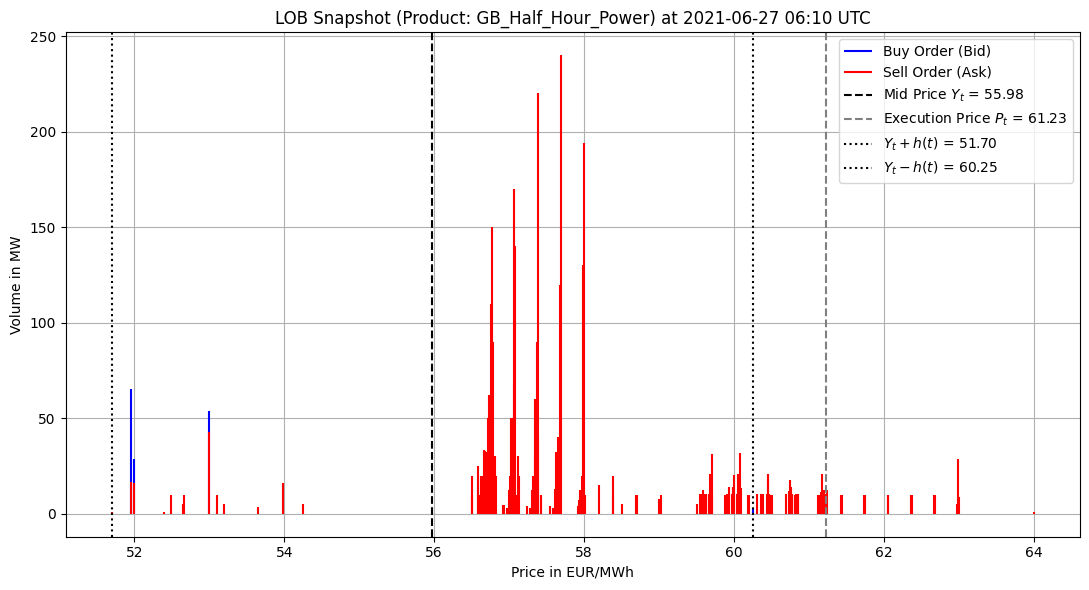

In [17]:
# Plot the LOB for the cleaned and filtered product
plt.figure(figsize=(11, 6))
plt.vlines(bid_grouped['Price'], 0, bid_grouped['Quantity'], color='blue', label='Buy Order (Bid)')
plt.vlines(ask_grouped['Price'], 0, ask_grouped['Quantity'], color='red', label='Sell Order (Ask)')
plt.axvline(Y_t, color='black', linestyle='--', label=f'Mid Price $Y_t$ = {Y_t:.2f}')
plt.axvline(P_t, color='gray', linestyle='--', label=f'Execution Price $P_t$ = {P_t:.2f}')
plt.axvline(Y_t + h_t, color='black', linestyle=':', label=f'$Y_t + h(t)$ = {Y_t + h_t:.2f}')
plt.axvline(Y_t - h_t, color='black', linestyle=':', label=f'$Y_t - h(t)$ = {Y_t - h_t:.2f}')

plt.xlabel('Price in EUR/MWh')
plt.ylabel('Volume in MW')
plt.title(f'LOB Snapshot (Product: GB_Half_Hour_Power) at {active_bucket.strftime("%Y-%m-%d %H:%M UTC")}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
